<a href="https://colab.research.google.com/github/chielgroen1998/DL_group_22/blob/main/model_testingVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
!pip install tensorflow
!pip install --upgrade opencv-python

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [3]:
# to download from
file_id = "1el92N8lBia2a5RFK0leeFQFRyhsEXaZx"
!gdown --id {file_id} -O rare_species.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx
From (redirected): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx&confirm=t&uuid=cb93287c-c7a2-44c8-af30-e3555f62beb9
To: /content/rare_species.zip
100% 4.26G/4.26G [00:52<00:00, 80.6MB/s]


In [4]:


# verify file size
!ls -lh rare_species.zip

# directory creation for excation
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")


# extraction
print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

# list fo contents for double-check
!ls -la {extract_path}

csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")




-rw-r--r-- 1 root root 4.0G Apr 11 12:01 rare_species.zip
Created directory: /content/rare_species
Extracting zip 
Extraction complete
total 2920
drwxr-xr-x 204 root root   12288 Apr 22 14:57 .
drwxr-xr-x   1 root root    4096 Apr 22 14:57 ..
drwxr-xr-x   2 root root   12288 Apr 22 14:57 arthropoda_apidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_attelabidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_carabidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_cerambycidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_coenagrionidae
drwxr-xr-x   2 root root   20480 Apr 22 14:57 arthropoda_formicidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_gomphidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_lucanidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_nymphalidae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_palinuridae
drwxr-xr-x   2 root root    4096 Apr 22 14:57 arthropoda_papilionidae
drwxr

In [5]:

# definitions basic

DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
MIN_RESOLUTION = (100, 100)
CLASS_THRESHOLD = 10

tf.random.set_seed(SEED)
np.random.seed(SEED)


In [6]:

# data prep

def load_and_validate_data():
    """Load metadata and filter invalid/low-quality images"""
    metadata = pd.read_csv(os.path.join(DATA_PATH, 'metadata.csv'))
    metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join(DATA_PATH, x))

    # Validate images
    metadata['valid'] = metadata['file_path'].apply(
        lambda x: os.path.exists(x) and Image.open(x).size >= MIN_RESOLUTION
    )
    return metadata[metadata['valid']].drop(columns=['valid'])

def analyze_class_distribution(metadata):
    """Visualize class distribution and identify rare classes"""
    family_counts = metadata['family'].value_counts()

    plt.figure(figsize=(12, 6))
    sns.histplot(family_counts, bins=50)
    plt.title("Images per Family Distribution")
    plt.axvline(CLASS_THRESHOLD, color='r', linestyle='--')
    plt.show()

    rare_classes = family_counts[family_counts < CLASS_THRESHOLD]
    print(f"Rare families (<{CLASS_THRESHOLD} images): {len(rare_classes)}")


In [7]:

# creating dataset
def create_datasets(metadata):

    # splitting with stratification

    train_df, val_df = train_test_split(
        metadata,
        test_size=0.2,
        stratify=metadata['family'],
        random_state=SEED
    )

    # lookup for family and phylum

    family_lookup = tf.keras.layers.StringLookup()
    family_lookup.adapt(metadata['family'])
    phylum_lookup = tf.keras.layers.StringLookup()
    phylum_lookup.adapt(metadata['phylum'])

# defining preprocessing

    def preprocess(row):
        img = tf.io.read_file(row['file_path'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img, family_lookup(row['family'])

    def make_dataset(df):
        return tf.data.Dataset.from_tensor_slices(dict(df)) \
            .map(preprocess, num_parallel_calls=AUTOTUNE) \
            .batch(BATCH_SIZE) \
            .prefetch(AUTOTUNE)

    return make_dataset(train_df), make_dataset(val_df), family_lookup


In [8]:
# ========================
# building model
# ========================
def build_transfer_model(num_classes):

    base_model = tf.keras.applications.EfficientNetB0( # interchange with efficientnetb7,
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # Freeze base layers

    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


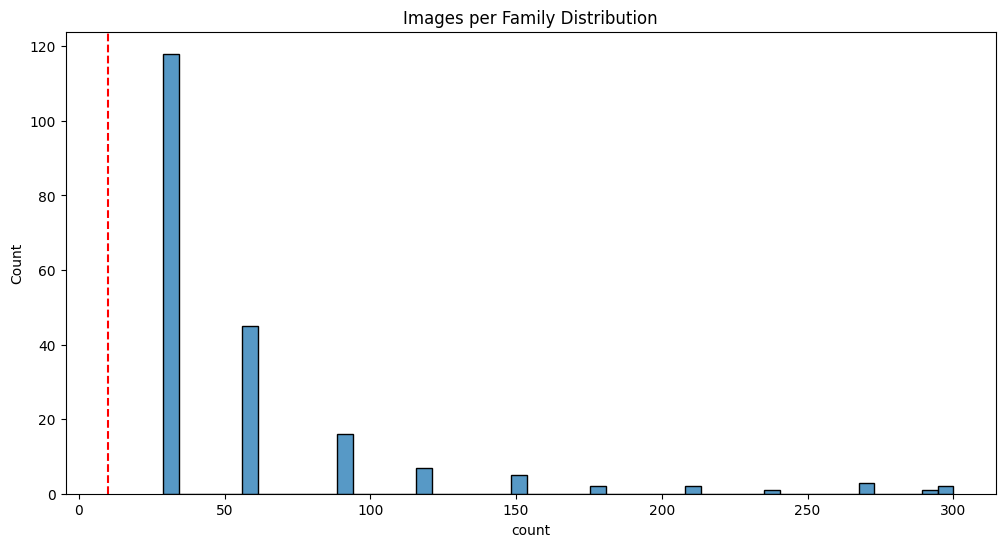

Rare families (<10 images): 0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
 18/150 ━━━━━━━━━━━━━━━━━━━━ 13:16 6s/step - accuracy: 0.0403 - loss: 5.1793

In [ ]:

# model execution and calling in before defined definitions

##### add confusion matrix and f1, f1macro etc

def main():
    metadata = load_and_validate_data()
    analyze_class_distribution(metadata)


    train_ds, val_ds, family_lookup = create_datasets(metadata)

    model = build_transfer_model(len(family_lookup.get_vocabulary()))
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )



    # training with early stop
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                patience=3,
                restore_best_weights=True
            )
        ]
    )

    # Visualization #  <<<<<< f1macro etc ^ notes from above
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Classification Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
### run of best model w more epochs